In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import odr

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
    })

In [2]:
def f(p, x):
    """This is a line."""
    return p[0] * x + p[1]

lin_model = odr.Model(f)

def g(p, x):
    return p[0] / np.sqrt(x - p[1]) + p[2]

root_model = odr.Model(g)

def h(p, x):
    return p[0] / x**p[1] + p[2]

inv_model = odr.Model(h)


In [3]:
# mock slope and intercept
a = np.array([0.5, 0.3, 0.7, 0.9, 1.4])
b = np.array([0.01, 0.3, 0.04, 1.2, 9.4])

beta0 = np.array([a, b]).T

eF = 1. / np.sqrt(1 + np.sum(a**2)) * np.array([1.] + a)

xvals = np.linspace(-1,1,30)

# uncertainties on data points
sigma_meas = 1e-10

# spread of data points
nsigmadev = 10
sigma_pos = sigma_meas

In [4]:
sigma_pos / xvals

array([-1.00000000e-10, -1.07407407e-10, -1.16000000e-10, -1.26086957e-10,
       -1.38095238e-10, -1.52631579e-10, -1.70588235e-10, -1.93333333e-10,
       -2.23076923e-10, -2.63636364e-10, -3.22222222e-10, -4.14285714e-10,
       -5.80000000e-10, -9.66666667e-10, -2.90000000e-09,  2.90000000e-09,
        9.66666667e-10,  5.80000000e-10,  4.14285714e-10,  3.22222222e-10,
        2.63636364e-10,  2.23076923e-10,  1.93333333e-10,  1.70588235e-10,
        1.52631579e-10,  1.38095238e-10,  1.26086957e-10,  1.16000000e-10,
        1.07407407e-10,  1.00000000e-10])

In [5]:
sigma_pos / np.array([f(beta0, x) for x in xvals])

array([[-5.00000000e-10,  3.44827586e-10],
       [-6.04166667e-10,  3.44009490e-10],
       [-7.63157895e-10,  3.43195266e-10],
       [-1.03571429e-09,  3.42384888e-10],
       [-1.61111111e-09,  3.41578327e-10],
       [-3.62500000e-09,  3.40775558e-10],
       [ 1.45000000e-08,  3.39976553e-10],
       [ 2.41666667e-09,  3.39181287e-10],
       [ 1.31818182e-09,  3.38389732e-10],
       [ 9.06250000e-10,  3.37601863e-10],
       [ 6.90476190e-10,  3.36817654e-10],
       [ 5.57692308e-10,  3.36037080e-10],
       [ 4.67741935e-10,  3.35260116e-10],
       [ 4.02777778e-10,  3.34486736e-10],
       [ 3.53658537e-10,  3.33716916e-10],
       [ 3.15217391e-10,  3.32950631e-10],
       [ 2.84313725e-10,  3.32187858e-10],
       [ 2.58928571e-10,  3.31428571e-10],
       [ 2.37704918e-10,  3.30672748e-10],
       [ 2.19696970e-10,  3.29920364e-10],
       [ 2.04225352e-10,  3.29171396e-10],
       [ 1.90789474e-10,  3.28425821e-10],
       [ 1.79012346e-10,  3.27683616e-10],
       [ 1.

In [6]:
def eF(fitparams):

    F1 = np.insert(fitparams.T[0], 0, 1.)    

    return F1 / np.sqrt(F1 @ F1)

def sample_and_fit_pseudo_points(Nsamples, Ntransitions, x_values, sigma_pos, sigma_meas):
    """
    Generate Nsamples of the fit parameters by generating Nsamples versions of the points at the x_values.
    Each entry has dimension: [Ntransitions][2 (slope:0/intercept:1)]  
    Ntransitions: number of transition configs (01, 012, .... , 012...Ntransitions)

    Returns: numpy arrays of
       - fitparamsamples  dim: (Nsamples, Ntransitions, 2)
       - xsamples         dim: (Nsamples, Npts)
       - yvecsamples      dim: (Nsamples, Ntransitions, Npts)

       where Npts = len(x_values)

    """
    
    fitparamsamples = []

    xsamples = []
    sxsamples = []
    yvecsamples = []
    syvecsamples = []

    Nsamples = int(Nsamples)
    
    for s in range(Nsamples):

        fitparamsample = []
        
        np.random.seed(s)
        
        sampled_x = []
        sampled_yvec = []
        sampled_sx = []
        sampled_syvec = []
        
        for p, xp in enumerate(x_values):
            sampled_x.append(np.random.normal(xp, sigma_pos))
            sampled_sx.append(np.random.normal(0, sigma_meas))
            
        for jind in range(Ntransitions):
            sampled_yvec.append(np.array([np.random.normal(f([a[jind], b[jind]], xp), sigma_pos) for xp in x_values]))
            sampled_syvec.append(np.array([np.random.normal(0, sigma_meas) for xp in x_values]))

            data = odr.RealData(   
                x=sampled_x,
                y=sampled_yvec[jind],
                sx=sampled_sx,
                sy=sampled_syvec[jind])
            
            odr_obj = odr.ODR(data, lin_model, beta0=beta0[jind])
            out = odr_obj.run()
            fitparamsample.append(
                out.beta #[out.beta, out.sd_beta]
                )

        fitparamsamples.append(fitparamsample)
        xsamples.append(sampled_x)
        sxsamples.append(sampled_sx)
        yvecsamples.append(sampled_yvec)
        syvecsamples.append(sampled_syvec)


    return (np.asarray(fitparamsamples),  np.asarray(xsamples), np.asarray(yvecsamples))


def absd(fitparams, x, yvec):
    """
    Compute distance of pseudo_point from fitted line.
    fitparams dim: (Ntransitions, 2)
    x         dim: 1
    yvec      dim: Ntransitions
    
    """
    # print("absd")
    # print("fitparams", fitparams.shape)
    # print("x", x.shape)
    # print("yvec     ", yvec.shape)
    
    Ntransitions = len(fitparams)
    delta = np.array([0] + [yvec[i] - f(fitparams[i], x) for i in range(Ntransitions)])

    # print("delta", delta.shape)
    # print("eFvec", eF(fitparams).shape)

    eFvec = eF(fitparams)
    d = delta - (delta @ eFvec) * eFvec
    
    return np.linalg.norm(d)


def totabsd(fitparamsamples, xsamples, yvecsamples):
    """
    Compute sum_{points} absd(fitparamsample, point)**2 for each fitparamsample.
    Returns numpy array of length len(fitparamsamples).

       - fitparamsamples  dim: (Nsamples, Ntransitions, 2)
       - xsamples         dim: (Nsamples, Npts)
       - yvecsamples      dim: (Nsamples, Ntransitions, Npts)
    
    """

    totabsdsqlist = []
    Npts = xsamples.shape[1]

    for s, fitparamsample in enumerate(fitparamsamples):
        absds = np.array([absd(fitparamsample, xsamples[s][p], (yvecsamples[s].T)[p]) for p in range(Npts)])
        
        totabsdsqlist.append(np.sum(absds)/ Npts)

    return np.average(totabsdsqlist), np.std(totabsdsqlist)
 
    

# def logL(pseudo_points, fitparams):

#     absds = np.array([absd(fitparams, point) for point in pseudo_points])
#     covdd = np.cov(absds)


# def diff2target(Ntransitions, sampled_params, target_params):  #[i][slope:0/intercept:1]

#     diffs = np.array([
#         np.sum(np.array([
#             (sp[i][0] - target_params[i][0])**2 
#             + (sp[i][1] - target_params[i][1])**2
#             for i in range(Ntransitions)]))
#                for sp in sampled_params])
    
#     meandiff = np.average(diffs)
#     sigdiff = np.std(diffs)

#     return meandiff, sigdiff




def diff2target(Ntransitions, sampled_params, target_params):  #[i][slope:0/intercept:1]

    diffs = np.array([
        np.sqrt(
            np.sum(np.array([
                (sp[jind][0] - target_params[jind][0])**2 / target_params[jind][0]**2
                + (sp[jind][1] - target_params[jind][1])**2 / target_params[jind][1]**2
                for jind in range(Ntransitions)]))
        ) for sp in sampled_params])
    
    meandiff = np.average(diffs)
    sigdiff = np.std(diffs)

    return meandiff, sigdiff

# def param_likelihood(sampled_params, target_params):
#     ll = np.sum(np.array([
#         np.sum(np.array([
#             (sp[i][0] - target_params[i][0])**2  / sp[1][0]**2
#             + (sp[i][1] - target_params[i][1])**2  / sp[1][1]**2
#             for sp in sampled_params]))
#         for i in range(Ntransitions)]))
#     return ll

In [7]:
fps, xs, yvecs = sample_and_fit_pseudo_points(10, 1, xvals, sigma_pos, sigma_meas)
fps4plot = fps.reshape

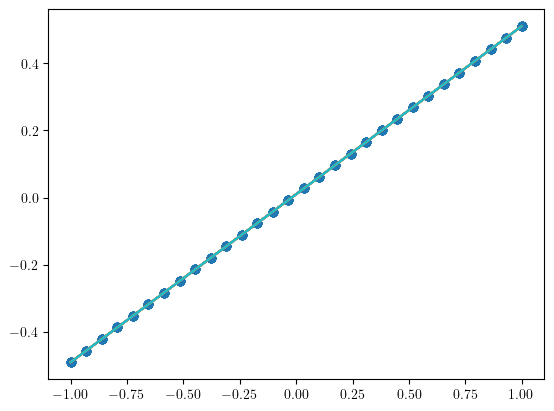

In [8]:
plt.scatter(xs, yvecs.reshape((10,30)))
for fp in fps:
    plt.plot(xvals, np.array([f(fp[0], x) for x in xvals]))

In [9]:
diff2target(1, fps, beta0)

(np.float64(4.22841365085562e-09), np.float64(3.061720341943797e-09))

In [10]:
totabsd(fps, xs, yvecs)

(np.float64(8.583042312795742e-11), np.float64(1.6417458407970027e-11))

In [11]:
xvals[:2]

array([-1.        , -0.93103448])

In [12]:
scaling_avg_diff2target_Nj = []
scaling_std_diff2target_Nj = []

scaling_avg_absd_Nj = []
scaling_std_absd_Nj = []

NtransRange = range(1, len(a) + 1) 
NptRange = range(2, len(xvals) + 1)
Nvals = np.linspace(2, len(xvals) + 1, 1000)

for Ntrans in NtransRange:
    
    scaling_avg_diff2target_Npts = []
    scaling_std_diff2target_Npts = []
    
    scaling_avg_absd_Npts = []
    scaling_std_absd_Npts = []
    
    for Npts in NptRange:
        # scaling_paramlikelihood_Npts = []
        
        (fitparamsamples, 
         xsamples, yvecsamples) = sample_and_fit_pseudo_points(
            Nsamples=500,
            Ntransitions=Ntrans,
            x_values=xvals[:Npts],
            sigma_pos=sigma_pos,
            sigma_meas=sigma_meas,
        )
        avgdiff, stdiff = diff2target(
            Ntransitions=Ntrans,
            sampled_params=fitparamsamples,
            target_params=beta0,
        )
        scaling_avg_diff2target_Npts.append(avgdiff)
        scaling_std_diff2target_Npts.append(avgdiff)

        avgtotabsd, stdtotabsd = totabsd(fitparamsamples, xsamples, yvecsamples)
        scaling_avg_absd_Npts.append(avgtotabsd)
        scaling_std_absd_Npts.append(stdtotabsd)

    scaling_avg_diff2target_Nj.append(scaling_avg_diff2target_Npts)
    scaling_std_diff2target_Nj.append(scaling_std_diff2target_Npts)
    
    scaling_avg_absd_Nj.append(scaling_avg_absd_Npts)
    scaling_std_absd_Nj.append(scaling_std_absd_Npts)

scaling_avg_diff2target_Ntransitions = np.array(scaling_avg_diff2target_Nj)
scaling_std_diff2target_Ntransitions = np.array(scaling_std_diff2target_Nj)

scaling_avg_absd_Ntransitions = np.array(scaling_avg_absd_Nj)
scaling_std_absd_Ntransitions = np.array(scaling_std_absd_Nj)

In [13]:
Npts4sqrtfit = 15 
Nvals4sqrtfit = np.linspace(min(Nvals), Nvals[np.argmin(np.abs(Nvals - NptRange[Npts4sqrtfit]))], 1000)
NtransRange4sqrtfit = [1, 5]

thetadiffdata = odr.RealData(
    x=np.array(list(NptRange[:Npts4sqrtfit]) * len(NtransRange)),
    y=np.array([scaling_avg_diff2target_Ntransitions[Ntrans - 1][:Npts4sqrtfit] for Ntrans in NtransRange]).flatten(),
    sy=np.array([scaling_std_diff2target_Ntransitions[Ntrans - 1][:Npts4sqrtfit] for Ntrans in NtransRange]).flatten(),
)
odr_obj = odr.ODR(thetadiffdata, root_model, 
                  beta0=[np.average(scaling_avg_diff2target_Ntransitions[-1][:3]) / np.exp(3 / 2), 1, 0])
out = odr_obj.run()
thetafitparams = out.beta
thetafitparams

/tmp/ipykernel_15085/3131417792.py:8: RuntimeWarning: invalid value encountered in sqrt
  return p[0] / np.sqrt(x - p[1]) + p[2]


array([ 1.26817826e-07,  1.73632638e+00, -2.72841797e-08])

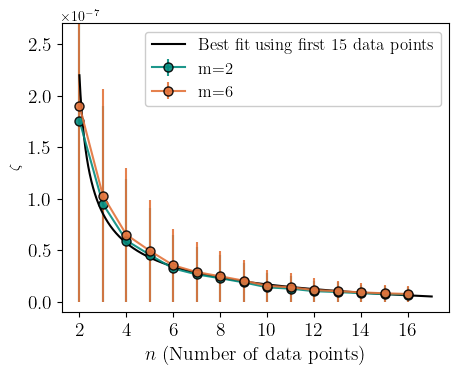

In [58]:
default_colour = [
    '#048c7f',
    "#a16edb",
    "#9467bd",
    "#8c564b",
    '#e3733b',
]

thetadiff_colour = [default_colour[0], default_colour[4]]

fig, ax = plt.subplots(figsize=(5, 5 * 6 / 8), dpi=100)
for n, Ntrans in enumerate(NtransRange4sqrtfit):
    plt.errorbar(NptRange[:Npts4sqrtfit], 
             scaling_avg_diff2target_Ntransitions[Ntrans - 1][:Npts4sqrtfit],
             yerr=scaling_std_diff2target_Ntransitions[Ntrans - 1][:Npts4sqrtfit],
             markersize=13, marker=".", label=f"m={Ntrans + 1}", color=thetadiff_colour[n], 
             mec="black", alpha=0.9)
plt.plot(Nvals4sqrtfit, g(thetafitparams, Nvals4sqrtfit), color='k', mec="black", 
         label=f"Best fit using first {len(NptRange[:Npts4sqrtfit])} data points"
# (
#              r"Best fit to " 
#              + r" $y = \frac{\theta_1}{\sqrt{n-\theta_2}} + \theta_3 $"   + "\n" 
#              + f" using first {len(NptRange[:Npts4sqrtfit])} data points "
#              + r"$(n, \zeta)$"
#              + "\n" 
#              + r"$(\theta_1, \theta_2, \theta_3)\approx$" f"({thetafitparams[0]:.0e}, {thetafitparams[1]:.1f}, {thetafitparams[2]:.0e})"
# )
        )
plt.xlabel("$n$ (Number of data points)", fontsize=14)
# plt.ylabel(r"$\zeta = \left\langle \sqrt{\sum_{j=2}^m \left(\frac{(m_j^{(s)} - m_j)^2}{m_j^2} + \frac{(c_j^{(s)} - c_j)^2}{c_j^2}\right)}\right\rangle_{\!\!(s)}$", fontsize=14)
plt.ylabel(r"$\zeta$")
plt.legend(fontsize=12, framealpha=1)
plt.ylim(-0.1e-7, 2.7e-7)
# plt.title(r"Fit of $\lbrace(x_a, y_a)\rbrace_{a=1}^n$ to $f(x)=mx + c$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("thetadiff.pdf", bbox_inches="tight")

In [15]:
# ddiffdata = odr.RealData(
#     x=np.array(list(NptRange[1:]) * len(NtransRange)),
#     y=np.array([scaling_avg_absd_Ntransitions[Ntrans - 1][1:] for Ntrans in NtransRange]).flatten(),
#     sy=np.array([scaling_std_absd_Ntransitions[Ntrans - 1][1:] for Ntrans in NtransRange]).flatten(),
# )
ddiffdata = odr.RealData(
    x=NptRange[:Npts4sqrtfit],
    y=scaling_avg_absd_Ntransitions[0][:Npts4sqrtfit],
    sy=scaling_std_absd_Ntransitions[0][:Npts4sqrtfit],
)
odr_obj = odr.ODR(ddiffdata, root_model, beta0=[-1e-1, 1.7, 1e-1])
out = odr_obj.run()
ddiffitparams = out.beta
ddiffitparams

array([-5.57132794e-11,  1.68629439e+00,  9.83257511e-11])

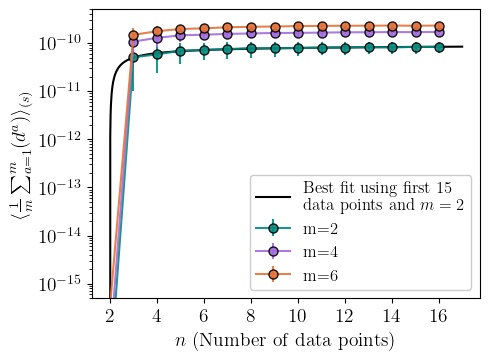

In [65]:
NtransRange4ddiff = [1, 3, 5]
ddiff_colour = [default_colour[0], default_colour[1], default_colour[4]]

fig, ax = plt.subplots(figsize=(5, 5 * 6 / 8))
for n, Ntrans in enumerate(NtransRange4ddiff):
    plt.errorbar(NptRange[:Npts4sqrtfit], 
             scaling_avg_absd_Ntransitions[Ntrans - 1][:Npts4sqrtfit],
             yerr=scaling_std_absd_Ntransitions[Ntrans - 1][:Npts4sqrtfit],
             markersize=13, marker=".", label=f"m={Ntrans + 1}", color=ddiff_colour[n],
             mec="black", alpha=0.9)
#plt.plot(Npts, scaling_diff2target[-1] / np.exp(np.exp(3 / 2)) *  np.exp(np.exp([(n + 1) / n for n in Npts])))
# plt.plot(NptRange, 
#          scaling_diff2target_Ntransitions[0] / np.exp(np.exp(np.exp(np.sqrt(3 / 2)))) 
#          *  np.exp(np.exp(np.exp([np.sqrt((n + 1) / n)
#                                   for n in NptRange]))))
plt.plot(Nvals4sqrtfit[:-2], g(ddiffitparams, Nvals4sqrtfit)[:-2], 'k', 
         label=(
             f"Best fit using first {len(NptRange[:Npts4sqrtfit])}" 
             + "\n"
             + r"data points and $m=2$"
         )
        )
         # label=(
         #     f"Best fit to " 
         #     + r" $y = \frac{\theta_1}{\sqrt{n-\theta_2}} + \theta_3 $ using"
         #     + "\n" 
         #     + f"first {len(NptRange[:Npts4sqrtfit])} data points for " 
         #     + r"$m=2$."
         #     + "\n" 
         #     + r"$(\theta_1, \theta_2, \theta_3)\approx$" f"({ddiffitparams[0]:.0e}, {ddiffitparams[1]:.1f}, {ddiffitparams[2]:.0e})"))
plt.yscale("log")
plt.xlabel("$n$ (Number of data points)", fontsize=14)
plt.ylabel(r"$\langle \frac{1}{m}\sum_{a=1}^m (d^a) \rangle_{(s)}$", fontsize=14)
# plt.tight_layout()
plt.legend(loc="lower right", fontsize=12, framealpha=1)

#plt.plot(Nvals, np.array([g([-1e-1, 1, 1e-1], Nv) for Nv in Nvals]))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([5e-16,5e-10])
# ax.yaxis.offsetText.set_fontsize(14)
# plt.title(r"Fit of $\lbrace(x_a, y_a)\rbrace_{a=1}^n$ to $f(x)=mx + c$", fontsize=14)
plt.savefig("ddiff.pdf", bbox_inches="tight")

In [103]:
(g(ddiffitparams, 3)/ g(ddiffitparams, 100000000000000))

np.float64(0.38658713856867116)

In [109]:
scaling_avg_absd_Ntransitions[0][1]/ g(ddiffitparams, 100000000000000)

np.float64(0.3133984883373246)

In [111]:
# Ca3pointTEST
(3.59 + 1.51) * 1e-11 / (2 * 4.81 * 1e-10)

0.053014553014553004

In [110]:
# Ca10pointTEST
(1.65 - 0.32) * 1e-10 / (2 * 1.31 * 1e-10)

0.5076335877862594

In [118]:
# Ca24min_mod / Ca24min alg
1.38 * 1e-6 / (4.74 * 1e-10)

2911.392405063291

In [117]:
# Ca24min_mod / Ca24min kifit
(2.42 + 2.57) * 1e-9 / ((2.55 + 2.66) * 1e-11)

95.77735124760079

In [166]:
ddiffnormdata = odr.RealData(
    x=NptRange[:15],
    y=(scaling_avg_absd_Ntransitions[0][:15] / scaling_std_absd_Ntransitions[0][:15])**2)
odr_obj = odr.ODR(ddiffnormdata, inv_model, beta0=[-20, 2, 10])
out = odr_obj.run()
ddiffnormfitparams = out.beta
ddiffnormfitparams

/tmp/ipykernel_5406/179248767.py:13: RuntimeWarning: invalid value encountered in power
  return p[0] / x**p[1] + p[2]


array([-1.67561333e+02,  7.89648975e-02,  1.51740397e+02])

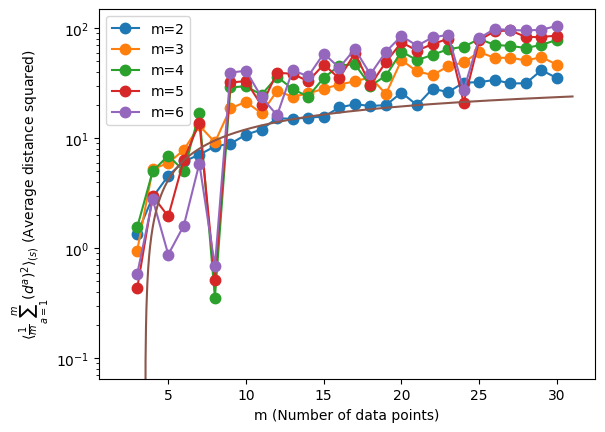

In [167]:
for Ntrans in NtransRange:
    plt.plot(NptRange[1:], 
             (scaling_avg_absd_Ntransitions[Ntrans - 1][1:] / scaling_std_absd_Ntransitions[Ntrans - 1][1:])**2,
             markersize=15, marker=".", label=f"m={Ntrans + 1}")
#plt.plot(Npts, scaling_diff2target[-1] / np.exp(np.exp(3 / 2)) *  np.exp(np.exp([(n + 1) / n for n in Npts])))
# plt.plot(NptRange, 
#          scaling_diff2target_Ntransitions[0] / np.exp(np.exp(np.exp(np.sqrt(3 / 2)))) 
#          *  np.exp(np.exp(np.exp([np.sqrt((n + 1) / n)
#                                   for n in NptRange]))))
plt.plot(Nvals, h(ddiffnormfitparams, Nvals))
plt.yscale("log")
plt.xlabel("m (Number of data points)")
plt.ylabel(r"$\langle \frac{1}{m}\sum_{a=1}^m (d^a)^2 \rangle_{(s)}$ (Average distance squared)")
plt.legend()

a bit crappy...

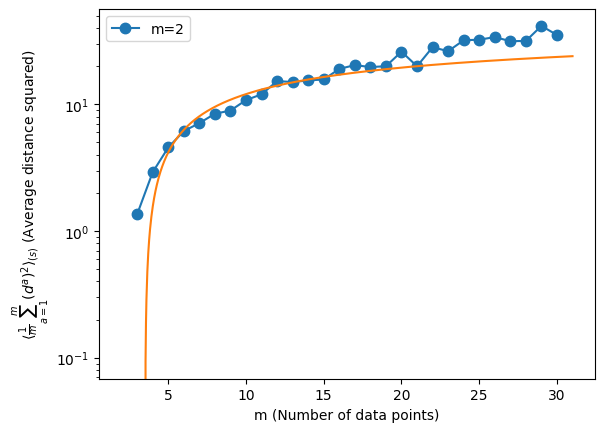

In [168]:
plt.plot(NptRange[1:],
         (scaling_avg_absd_Ntransitions[0][1:] / scaling_std_absd_Ntransitions[0][1:])**2,
             markersize=15, marker=".", label="m=2")
plt.plot(Nvals, h(ddiffnormfitparams, Nvals))
plt.yscale("log")
plt.xlabel("m (Number of data points)")
plt.ylabel(r"$\langle \frac{1}{m}\sum_{a=1}^m (d^a)^2 \rangle_{(s)}$ (Average distance squared)")
plt.legend()